In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/code/DL

/content/drive/MyDrive/code/DL


In [3]:
import os
import sys 
import pandas as pd
import numpy as np
from tqdm import tqdm
import shutil
import glob
import h5py
import seaborn as sns
import matplotlib.pyplot as plt
import soundfile as sf
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.functional import Tensor
import torch.optim as opt
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms, utils
from sklearn.model_selection import train_test_split

sys.path.insert(0, '/content/drive/MyDrive/pkgs/')
sys.path.insert(0, '../lib/')
from uti import get_f_name, play_audio,plot_waveform, plot_specgram, plot_spectrogram
from cf_matrix import make_confusion_matrix

ad_dir = '../processed_data/Pitt/AD/par_audio/norm4'
control_dir = '../processed_data/Pitt/Control/par_audio/norm4'
annot = pd.read_csv('../data/annotation.csv')

In [4]:
import librosa
import sox
import torchaudio
import torchaudio.transforms as T
import torchaudio.functional as audio_F
from torchaudio import sox_effects
from einops import rearrange, reduce, repeat
from dataset import MyDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(device))
print(torch.cuda.get_device_properties(device))

SoX could not be found!

    If you do not have SoX, proceed here:
     - - - http://sox.sourceforge.net/ - - -

    If you do (or think that you should) have SoX, double-check your
    path variables.
    


cuda
Tesla P100-PCIE-16GB
_CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)


In [9]:
df = pd.DataFrame(columns=['path','label'])
list_c = get_f_name(control_dir)
list_c.remove('172-0_norm.wav')
for i in sorted(list_c):
    path = os.path.join(control_dir, i)
    info = torchaudio.info(path)
    df = df.append({'path':path,'label':0,'num_frames': info.num_frames,'sr':info.sample_rate},ignore_index=True)
for i in sorted(get_f_name(ad_dir)):
    path = os.path.join(ad_dir,i)
    info = torchaudio.info(path)
    df = df.append({'path':path,'label':1,'num_frames': info.num_frames,'sr':info.sample_rate},ignore_index=True)
df.to_csv('../data/dl_annot.csv', index=False)

In [5]:
df = pd.read_csv('../data/dl_annot.csv')

In [6]:
df

path  ...       sr
0    ../processed_data/Pitt/Control/par_audio/norm4...  ...  44100.0
1    ../processed_data/Pitt/Control/par_audio/norm4...  ...  44100.0
2    ../processed_data/Pitt/Control/par_audio/norm4...  ...  44100.0
3    ../processed_data/Pitt/Control/par_audio/norm4...  ...  44100.0
4    ../processed_data/Pitt/Control/par_audio/norm4...  ...  44100.0
..                                                 ...  ...      ...
546  ../processed_data/Pitt/AD/par_audio/norm4/704-...  ...  44100.0
547  ../processed_data/Pitt/AD/par_audio/norm4/705-...  ...  44100.0
548  ../processed_data/Pitt/AD/par_audio/norm4/707-...  ...  44100.0
549  ../processed_data/Pitt/AD/par_audio/norm4/711-...  ...  44100.0
550  ../processed_data/Pitt/AD/par_audio/norm4/714-...  ...  44100.0

[551 rows x 4 columns]

In [15]:
df['duration'] = df.num_frames / df.sr

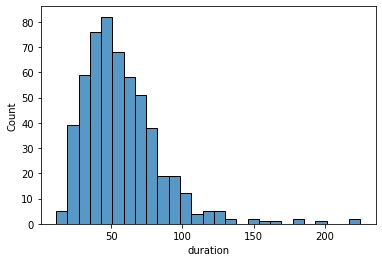

In [23]:
sns.histplot(df.duration)

In [ ]:
pkgs_path = '/content/drive/MyDrive/pkgs/'
os.makedirs(pkgs_path, exist_ok=True)

In [ ]:
!pip install --target=$pkgs_path  einops torchbearer livelossplot sox torchaudio catboost librosa

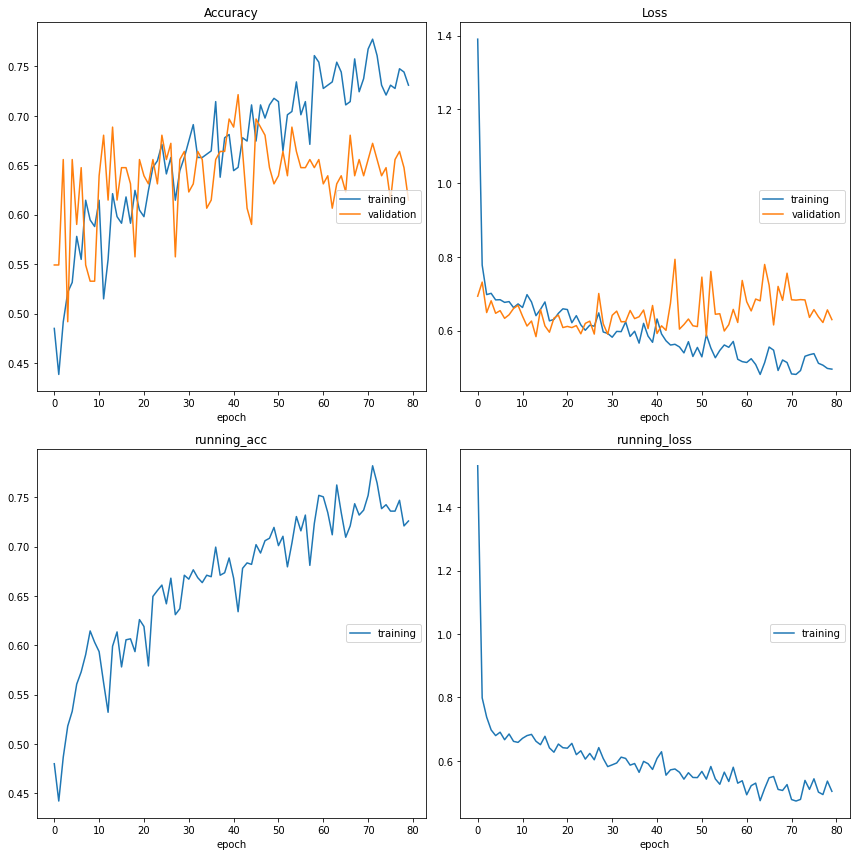

In [ ]:
from trial import trainer
from torch.optim import lr_scheduler
from torchbearer.callbacks import MultiStepLR, Best, LiveLossPlot
%matplotlib inline
plot = LiveLossPlot()

opt_params = {'lr':1e-4} #'momentum':0.9}

checkpoint = Best(filepath='../logs/vision_transfomer/model.'+transform_type+'.{epoch:02d}-{val_loss:.2f}.pt', monitor='val_acc', mode='max')
scheduler = MultiStepLR(milestones=[30, 60], gamma=0.5, step_on_batch=True)

def loss(inputs,labels):
    return nn.CrossEntropyLoss()(inputs, labels.long())

trial = trainer(m, loss_func=loss, device=device, metrics=['loss','accuracy'], opt=opt.Adam, verbose=2, trial_name=' ', opt_params=opt_params) 

trial.call_backs=[plot, checkpoint]
trial.init_trial() 

out = trial.run(80, tr_loader=tr_loader, val_loader=t_loader)

In [ ]:
y_pre,y_target = trial.fit_cuda_TensorDataset(m, t_data, 20)

In [ ]:
print(metrics.classification_report(y_target,y_pre,target_names=['Control','AD'], labels=[0,1]))

              precision    recall  f1-score   support

     Control       0.70      0.67      0.69        55
          AD       0.74      0.76      0.75        67

    accuracy                           0.72       122
   macro avg       0.72      0.72      0.72       122
weighted avg       0.72      0.72      0.72       122



In [ ]:
m.load_state_dict(torch.load('../logs/vision_transfomer/model.spec.41-0.61.pt')['model'])

<All keys matched successfully>

Test input shape

In [ ]:
sr = int(44100/2)
args = {'n_fft':512,'win_length':512,'hop_length':512,'n_mels':128,'n_mfcc':128,'top_db':80}
d = 70
transform_type = 'spec'
patches_size = 32
cv = 0
t = 0
log_v = 'norm4'
t_data  = MyDataset(annot_file = save_path+f'dl_annot_t_cv_{cv}_{t}_{log_v}.csv',
                      target_sr=sr,
                      num_samples = d*sr, 
                      #effects = [['gain', '-n']],
                      #effects = tfm,
                      transform = transform_type,
                      args = args,
                      if_time_shift = False,
                      if_spectro_augmentation = False, 
                      split_n_chunk = None,
                      if_patches = patches_size)
t_data[0][0].shape

perpare cv-folds

In [14]:
from sklearn.model_selection import StratifiedKFold, KFold
for t in range(3):
  skf = KFold(n_splits = 4, shuffle=True)

  df = pd.read_csv('../data/dl_annot.csv')
  df.path = df.path.apply(lambda s: s.replace('\\','/'))
  id_list = df.path.apply(lambda s: os.path.basename(s).split('_')[0]).values
  #id_list = df.path.apply(lambda s: os.path.basename(s).split('.')[0]).values

  log_v = 'norm4'
  selected_id = np.load('../data/selected_id3.npy') 
  save_path = '../data/data_dl/'
  selected_id = np.delete(selected_id, np.argwhere(selected_id == 172))
  os.makedirs(save_path, exist_ok=True)
  
  for cv, (tr_idx, t_idx) in enumerate(skf.split(selected_id)):
      #tr_idx, t_idx = train_test_split(selected_id, test_size=0.3)
      selected_idx_tr = [idx for idx,i in enumerate(id_list) if int(i.split('-')[0]) in selected_id[tr_idx]]
      selected_idx_t  = [idx for idx,i in enumerate(id_list) if int(i.split('-')[0]) in selected_id[t_idx]]
      print('segments num:', len(selected_idx_tr), len(selected_idx_t))
      print('subjects num:', len(set(tr_idx)), len(set(t_idx)))
      df.iloc[selected_idx_t].to_csv(save_path+f'dl_annot_t_cv_{cv}_{t}_{log_v}.csv',  index=False)
      df.iloc[selected_idx_tr].to_csv(save_path+f'dl_annot_tr_cv_{cv}_{t}_{log_v}.csv',index=False)

segments num: 292 97
subjects num: 128 43
segments num: 292 97
subjects num: 128 43
segments num: 295 94
subjects num: 128 43
segments num: 288 101
subjects num: 129 42
segments num: 297 92
subjects num: 128 43
segments num: 286 103
subjects num: 128 43
segments num: 295 94
subjects num: 128 43
segments num: 289 100
subjects num: 129 42
segments num: 291 98
subjects num: 128 43
segments num: 288 101
subjects num: 128 43
segments num: 295 94
subjects num: 128 43
segments num: 293 96
subjects num: 129 42


In [5]:
from trial import trainer
from torch.optim import lr_scheduler
from torchbearer.callbacks import MultiStepLR, Best, LiveLossPlot
from sklearn import metrics
import datetime

log_v = 'norm4'
tfm = sox.Transformer()
tfm.gain()

save_path = '../data/data_dl/'
def train_loop(t, cv, transform_type, args, d, patches_size, sr):
    torch.cuda.empty_cache()
    m = ViT(
    in_channels = 1,
    patch_size = (patches_size, patches_size),
    emb_size = 768*2,
    #img_size = (512, 1504),
    img_size = (256, 3008),
    depth = 12,
    n_classes = 2,
    num_heads = 8
    )
    tr_data = MyDataset( annot_file = save_path+f'dl_annot_tr_cv_{cv}_{t}_{log_v}.csv',
                        target_sr=sr,
                        num_samples = d*sr, 
                        #effects = [['gain', '-n']],
                        #effects = tfm,
                        transform =transform_type,
                        args = args,
                        if_time_shift = True,
                        if_spectro_augmentation = True, 
                        split_n_chunk = None,
                        if_patches = patches_size)

    t_data  = MyDataset( annot_file = save_path+f'dl_annot_t_cv_{cv}_{t}_{log_v}.csv',
                        target_sr=sr,
                        num_samples = d*sr, 
                        #effects = [['gain', '-n']],
                        #effects = tfm,
                        transform = transform_type,
                        args = args,
                        if_time_shift = False,
                        if_spectro_augmentation = False, 
                        split_n_chunk = None,
                        if_patches = patches_size)

    params = {'batch_size':20,'shuffle':True,'num_workers':2}
    tr_loader = DataLoader(tr_data,**params)
    t_loader  = DataLoader(t_data, **params)


    e = datetime.datetime.now()
    t_str = '{}.{}.{}.'.format(e.hour, e.minute, e.second)

    check_p_dir = f'../logs/vision_transfomer/t_{t}/cv_{cv}/'
    os.makedirs(check_p_dir,exist_ok=True)

    checkpoint = Best(filepath=check_p_dir+'model.'+t_str+transform_type+'.{epoch:02d}-{val_loss:.2f}.pt', monitor='val_acc', mode='max')
    scheduler = MultiStepLR(milestones=[30, 60], gamma=0.5)

    %matplotlib inline
    plot = LiveLossPlot()

    opt_params = {'lr':1e-4} #'momentum':0.9}

    def loss(inputs,labels):
        return nn.CrossEntropyLoss()(inputs, labels.long())

    trial = trainer(m, loss_func=loss, device=device, metrics=['loss','accuracy'], opt=opt.Adam, verbose=1, trial_name=' ', opt_params=opt_params) 
    
    trial.call_backs=[checkpoint]
    trial.init_trial() 

    out = trial.run(70, tr_loader=tr_loader, val_loader=t_loader)
    del t_data, tr_data
    torch.save(out, check_p_dir + f'out_t_{t}_cv_{cv}')
    print(t, cv)

training

In [22]:
from transformer import ViT
sr = int(44100/2)
args = {'n_fft':512,'win_length':512,'hop_length':512,'n_mels':128,'n_mfcc':128,'top_db':80}
#args = {'n_fft':1024,'win_length':1024,'hop_length':1024,'n_mels':128,'n_mfcc':128,'top_db':80}
d = 70
transform_type = ['spec','mel','mfcc'][0]
patches_size = 64
for t in range(3):
  for cv in range(4):
    train_loop(t, cv, transform_type, args, d, patches_size, sr)

  0%|          | 0/70 [00:00<?, ?it/s]

0 3


testing

In [5]:
from transformer import ViT
from trial import trainer
from sklearn import metrics 
log_v = 'norm4'
sr = int(44100/2)
#args = {'n_fft':1024,'win_length':1024,'hop_length':1024,'n_mels':128,'n_mfcc':128,'top_db':80}
args = {'n_fft':512,'win_length':512,'hop_length':512,'n_mels':128,'n_mfcc':128,'top_db':80}
d = 70
transform_type = 'spec'
patches_size = 64
m = ViT(
    in_channels = 1,
    patch_size = (patches_size, patches_size),
    emb_size = 768*2,
    #img_size = (512, 1504),
    img_size = (256, 3008),
    depth = 12,
    n_classes = 2,
    num_heads = 8)
  
opt_params = {'lr':1e-4} #'momentum':0.9}
def loss(inputs,labels):
  return nn.CrossEntropyLoss()(inputs, labels.long())

trial = trainer(m, loss_func=loss, device=device, metrics=['loss','accuracy'], opt=opt.Adam, verbose=2, trial_name=' ', opt_params=opt_params) 

trial.init_trial() 

y_pre_all,y_target_all,y_prob_all = [],[],[]
save_path = '../data/data_dl/'

print(save_path)

df_res = pd.DataFrame(columns=['type','t','cv','acc','recall-c','recall-a','pre-c','pre-a'])
for t in range(1):
  for cv in range(4):
      torch.cuda.empty_cache()
      t_data  = MyDataset(annot_file = save_path+f'dl_annot_t_cv_{cv}_{t}_{log_v}.csv',
                      target_sr=sr,
                      num_samples = d*sr, 
                      #effects = [['gain', '-n']],
                      #effects = tfm,
                      transform = transform_type,
                      args = args,
                      if_time_shift = False,
                      if_spectro_augmentation = False, 
                      split_n_chunk = None,
                      if_patches = patches_size)
      check_p_dir = check_p_dir = f'../logs/vision_transfomer/t_{t}/cv_{cv}/'
      saved_m = glob.glob(os.path.join(check_p_dir, f'model.*.{transform_type}.*.pt'))
      saved_m.sort(key=os.path.getctime, reverse=True)
      m.load_state_dict(torch.load(saved_m[0])['model'])
      m.eval()
      y_pre, y_target, y = trial.fit_cuda_TensorDataset(m, t_data, 20)

      recall   = metrics.recall_score(y_target, y_pre,average=None)
      precision = metrics.precision_score(y_target, y_pre,average=None)
      acc = metrics.accuracy_score(y_target, y_pre)
      auc = metrics.roc_auc_score(y_target, y_pre)
      df_res = df_res.append({'type':transform_type,'t':t,'cv':cv,'acc':acc,'recall-c':recall[0],
                      'recall-a':recall[1],'pre-c':precision[0],'pre-a':precision[1]},ignore_index=True)
      np.save(check_p_dir+f'res_y_{transform_type}', np.array(y))
      df_res.to_csv(check_p_dir+f'/res_{transform_type}.csv',index=False)

../data/data_dl/


In [21]:
del t_data

In [16]:
c = df_res[df_res.t==0]['pre-c']
ad= df_res[df_res.t==0]['pre-a']
print(np.mean([c,ad]))
print(np.std([c,ad]))

In [17]:
c = df_res[df_res.t==0]['recall-c']
ad= df_res[df_res.t==0]['recall-a']
print(np.mean([c,ad]))
print(np.std([c,ad]))

0.6617614148115818
0.13177969651065574


In [19]:
tem = df_res[df_res.t==0]

In [20]:
f1_1 = 2*(tem['pre-c']*tem['recall-c']/(tem['pre-c']+tem['recall-c']))
f1_2 = 2*(tem['pre-a']*tem['recall-a']/(tem['pre-a']+tem['recall-a']))
print(np.mean([f1_1.values,f1_2.values]))
print(np.std([f1_1.values,f1_2.values]))

0.6627244861339628
0.07507590196244886


In [6]:
df_res[df_res.t==0].describe()

acc  recall-c  recall-a     pre-c     pre-a
count  4.000000  4.000000  4.000000  4.000000  4.000000
mean   0.679042  0.702428  0.621095  0.685456  0.671063
std    0.032441  0.145171  0.144306  0.027737  0.042947
min    0.643564  0.568627  0.416667  0.658537  0.620690
25%    0.663468  0.613087  0.570833  0.670448  0.643545
50%    0.675477  0.669723  0.671111  0.679802  0.674638
75%    0.691051  0.759064  0.721373  0.694810  0.702156
max    0.721649  0.901639  0.725490  0.723684  0.714286

In [28]:
df_res[df_res.t==0]

type  t cv       acc  recall-c  recall-a     pre-c     pre-a
0  spec  0  0  0.721649  0.901639  0.416667  0.723684  0.714286
1  spec  0  1  0.670103  0.711538  0.622222  0.685185  0.651163
2  spec  0  2  0.680851  0.627907  0.725490  0.658537  0.698113
3  spec  0  3  0.643564  0.568627  0.720000  0.674419  0.620690

In [7]:
y_pre_all = []
y_target_all = []
y_ = []
for t in range(1):
  for cv in range(4):
    check_p_dir = f'../logs/vision_transfomer/t_{t}/cv_{cv}/'
    y = np.load(check_p_dir+f'res_y_{transform_type}.npy')
    y_.extend(torch.softmax(torch.from_numpy(y),1).numpy())
    y = torch.softmax(torch.from_numpy(y),1).argmax(1)
    y_pre_all.extend(y)
    df = pd.read_csv(save_path+f'dl_annot_t_cv_{cv}_{t}_{log_v}.csv')
    label = df.label.values
    y_target_all.extend(label)

In [8]:
fpr, tpr, threshold = metrics.roc_curve(y_target_all,np.array(y_)[...,1])
roc_auc = metrics.auc(fpr, tpr)

In [9]:
roc_auc

0.6947762382544991

In [10]:
id_list_pre = []
t=0
for cv in range(4):
  df = pd.read_csv(save_path+f'dl_annot_t_cv_{cv}_{t}_{log_v}.csv')
  tem = df.path.apply(lambda x: os.path.basename(x).split('_')[0]).values
  id_list_pre.extend(tem)

In [13]:
from uti import list_duplicates
new_list = [i.split('-')[0] for i in id_list_pre]

new_dic = list_duplicates(new_list)
y_pre_all =  np.array(y_pre_all)
y_target_all = np.array(y_target_all)
y_pre_=[]
y_true_=[]
for idx, (key,items) in enumerate(new_dic) :
    res = sum(y_pre_all[items])/y_pre_all[items].shape[0]
    y = np.array(y_target_all)[items]
    y_true_.append(y[0])
    if res >0.5:y_pre_.append(1)
    else: y_pre_.append(0)

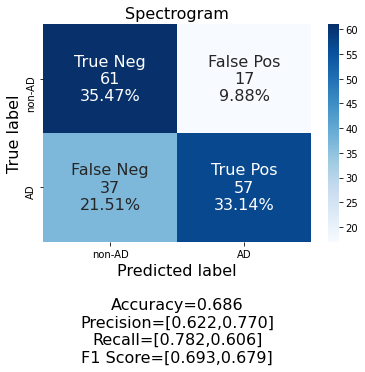

In [ ]:
from cf_matrix import make_confusion_matrix
from sklearn.metrics import confusion_matrix
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['non-AD', 'AD']
cf_matrix = confusion_matrix(y_true_, y_pre_)
make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues',
                      title = 'Spectrogram',
                      size=16)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 16
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true_,y_pre_, target_names=['Control','AD'], labels=[0,1]))

evaluate Chinese LU dataset

In [ ]:
ad_dir = '../processed_data/Lu/AD/par_audio/norm'

In [ ]:
df = pd.DataFrame(columns=['path','label'])
for i in sorted(get_f_name(ad_dir)):
    path = os.path.join(ad_dir,i)
    info = torchaudio.info(path)
    df = df.append({'path':path,'label':1,'num_frames': info.num_frames,'sr':info.sample_rate},ignore_index=True)
df.to_csv('../data/dl_annot_ch.csv', index=False)

In [ ]:
df = pd.read_csv('../data/dl_annot_ch.csv')
id_list = df.path.apply(lambda s: os.path.basename(s).split('_')[0]).values
#id_list = df.path.apply(lambda s: os.path.basename(s).split('.')[0]).values
selected_id =[i.split('_')[0] for i in get_f_name(ad_dir)]
tr_idx, t_idx = train_test_split(selected_id, test_size=0.6)
selected_idx_tr = [idx for idx,i in enumerate(id_list) if i in tr_idx]
selected_idx_t  = [idx for idx,i in enumerate(id_list) if i in t_idx]
print('subjects num:', len(set(tr_idx)), len(set(t_idx)))
df.iloc[selected_idx_t].to_csv('../data/dl_annot_t_ch.csv',  index=False)
df.iloc[selected_idx_tr].to_csv('../data/dl_annot_tr_ch.csv',index=False)

subjects num: 20 30


In [ ]:
tfm = sox.Transformer()
tfm.gain()
sr = int(44100/2)
args = {'n_fft':512,'win_length':512,'hop_length':512,'n_mels':128,'n_mfcc':128,'top_db':80}
d = 70
transform_type = 'spec'
patches_size = 32

tr_data = MyDataset( annot_file = '../data/dl_annot_tr_ch.csv',
                     target_sr=sr,
                     num_samples = d*sr, 
                     #effects = [['gain', '-n']],
                     #effects = tfm,
                     transform =transform_type,
                     args = args,
                     if_time_shift = True,
                     if_spectro_augmentation = True, 
                     split_n_chunk = None,
                     if_patches = patches_size)

t_data  = MyDataset( annot_file = '../data/dl_annot_t_ch.csv',
                     target_sr=sr,
                     num_samples = d*sr, 
                     #effects = [['gain', '-n']],
                     #effects = tfm,
                     transform = transform_type,
                     args = args,
                     if_time_shift = False,
                     if_spectro_augmentation = False, 
                     split_n_chunk = None,
                     if_patches = patches_size)

params = {'batch_size':10,'shuffle':True,'num_workers':2}
tr_loader = DataLoader(tr_data,**params)
t_loader  = DataLoader(t_data, **params)

In [ ]:
from trial import trainer
from torch.optim import lr_scheduler
from torchbearer.callbacks import MultiStepLR, Best, LiveLossPlot
from sklearn import metrics
import datetime
e = datetime.datetime.now()
t_str = '{}.{}.{}.'.format(e.hour, e.minute, e.second)

check_p_dir = '../logs/vision_transfomer/'
checkpoint = Best(filepath=check_p_dir+'model.'+t_str+transform_type+'.{epoch:02d}-{val_loss:.2f}.pt', monitor='val_acc', mode='max')
scheduler = MultiStepLR(milestones=[30, 60], gamma=0.5)

%matplotlib inline
plot = LiveLossPlot()

opt_params = {'lr':1e-4} #'momentum':0.9}

def loss(inputs,labels):
    return nn.CrossEntropyLoss()(inputs, labels.long())

trial = trainer(m, loss_func=loss, device=device, metrics=['loss','accuracy'], opt=opt.Adam, verbose=2, trial_name=' ', opt_params=opt_params) 

trial.call_backs=[plot, checkpoint]
trial.init_trial() 

In [ ]:
saved_m = glob.glob(os.path.join(check_p_dir, f'model.*.{transform_type}.*.pt'))
saved_m.sort(key=os.path.getctime, reverse=True)
m.load_state_dict(torch.load(saved_m[1])['model'])

<All keys matched successfully>

In [ ]:
m.eval()
y_pre,y_target = trial.fit_cuda_TensorDataset(m,t_data,10)

In [ ]:
print(metrics.classification_report(y_target,y_pre,target_names=['Control','AD'], labels=[0,1]))

              precision    recall  f1-score   support

     Control       0.67      0.69      0.68        65
          AD       0.70      0.68      0.69        68

    accuracy                           0.68       133
   macro avg       0.68      0.68      0.68       133
weighted avg       0.68      0.68      0.68       133



In [ ]:
ct = 0
for layers, child in enumerate(m.children()):
  if layers ==1:
      for ch in child:
        ct+=1
        if ct < 9:
          ch.requires_grad_ = False

In [ ]:
out = trial.run(30, tr_loader=tr_loader, val_loader=t_loader)

In [ ]:
m.eval()
y_pre,y_target = trial.fit_cuda_TensorDataset(m,t_data,10)

In [ ]:
print(metrics.classification_report(y_target,y_pre,target_names=['Control','AD'], labels=[0,1]))

              precision    recall  f1-score   support

     Control       0.00      0.00      0.00        65
          AD       0.51      1.00      0.68        68

    accuracy                           0.51       133
   macro avg       0.26      0.50      0.34       133
weighted avg       0.26      0.51      0.35       133



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
torch.randn(31, 100)